Text(0.5, 1.0, 'Original image')

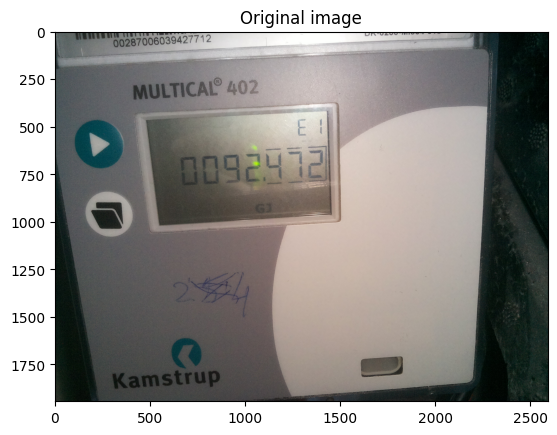

In [143]:
from matplotlib import pyplot as plt
import numpy as np
import pytesseract
import cv2

img_path = './img/readings-1.jpg'

# Load the input image and convert to RGB for correct display
image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
orig = image.copy()

plt.imshow(orig)
plt.title('Original image')

77 144


Text(0.5, 1.0, 'Dilated image')

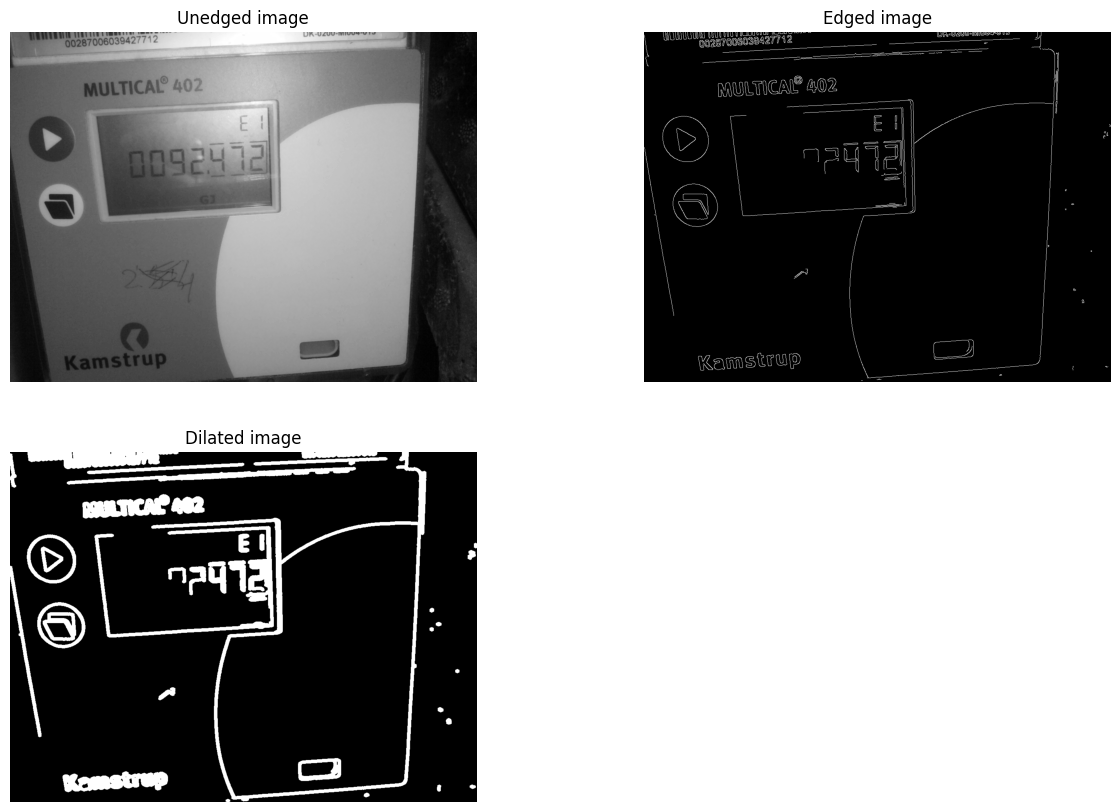

In [144]:
edge_find_image_height = 900
find_display_image = orig.copy()
find_display_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# Resize the image for more accurate contour detection
(h, w) = find_display_image.shape[:2]
ratio = edge_find_image_height / float(h)
dim = (int(w * ratio), edge_find_image_height)
find_display_image = cv2.resize(find_display_image, dim, interpolation=cv2.INTER_AREA)

# Apply blur and detect edges
find_display_image = cv2.GaussianBlur(find_display_image, (3, 3), 0)
sigma = 0.3
median = np.median(find_display_image)
lower = int(max(0, (1.0 - sigma) * median))
upper = int(min(255, (1.0 + sigma) * median))
edged = cv2.Canny(find_display_image, lower, upper)
print(lower, upper)

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
dilated = cv2.dilate(edged, kernel, iterations=2)

fig = plt.figure(figsize=(15, 10))
fig.add_subplot(2, 2, 1)
plt.imshow(find_display_image, cmap='gray')
plt.axis('off')
plt.title('Unedged image')

fig.add_subplot(2, 2, 2)
plt.imshow(edged, cmap='gray')
plt.axis('off')
plt.title('Edged image')

fig.add_subplot(2, 2, 3)
plt.imshow(dilated, cmap='gray')
plt.axis('off')
plt.title('Dilated image')

Found 71 total contours out of which 22 are rectangular
Display ROI: [[ 470  462]
 [1442  414]
 [1462  967]
 [ 539 1023]]


Text(0.5, 1.0, 'Original image')

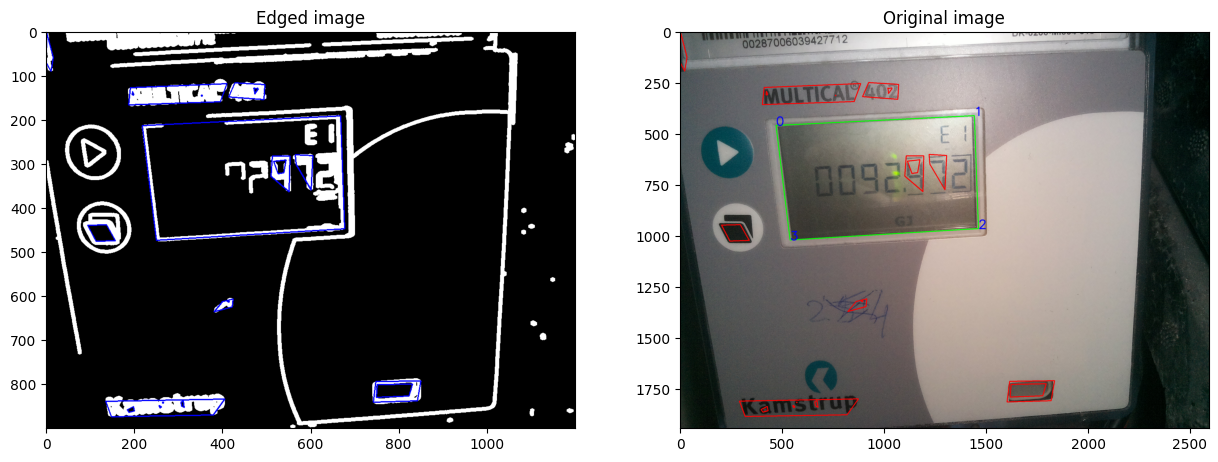

In [145]:
contours_original_image = orig.copy()
contours_detection_image = cv2.cvtColor(dilated.copy(), cv2.COLOR_GRAY2RGB)

def get_rectangular_contours(contours):
    res = []
    for contour in contours:
        peri = cv2.arcLength(contour, closed=True)
        approx = cv2.approxPolyDP(contour, 0.04 * peri, closed=True)
        hull = cv2.convexHull(approx)
        if len(hull) == 4:
            res.append(hull)
    return res

def get_scaled_contour(contour):
    return np.floor_divide(contour, ratio).astype(int)

contours, _ = cv2.findContours(dilated, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

rectangular_contours = get_rectangular_contours(contours)
scaled_rectangular_contours = [get_scaled_contour(c) for c in rectangular_contours]
print(f'Found {len(contours)} total contours out of which {len(rectangular_contours)} are rectangular')

# Assume that display contour is the largest contour with 4 vertices
sorted_scaled_contours = sorted(scaled_rectangular_contours, key=cv2.contourArea, reverse=True)
display_contour = next((c for c in sorted_scaled_contours if len(c) == 4), None)

# Normalize rectangular ROI for vertices to have deterministic indexes
display_roi = display_contour.reshape(4, 2)
moments = cv2.moments(display_contour)
cx = int(moments['m10'] / moments['m00'])
cy = int(moments['m01'] / moments['m00'])
display_roi_top_left = next((v for v in display_roi if v[0] < cx and v[1] < cy))
display_roi_top_right = next((v for v in display_roi if v[0] > cx and v[1] < cy))
display_roi_bottom_left = next((v for v in display_roi if v[0] < cx and v[1] > cy))
display_roi_bottom_right = next((v for v in display_roi if v[0] > cx and v[1] > cy))
display_roi = np.int32([display_roi_top_left, display_roi_top_right, display_roi_bottom_right, display_roi_bottom_left])
print(f'Display ROI: {display_roi}')

cv2.drawContours(contours_detection_image, rectangular_contours, -1, (0, 0, 255), 2)
cv2.drawContours(contours_original_image, scaled_rectangular_contours, -1, (255, 0, 0), 3)
cv2.drawContours(contours_original_image, [display_contour], -1, (0, 255, 0), 3)

# Draw vertex indices
for i in range(len(display_roi)):
    cv2.putText(contours_original_image, str(i), display_roi[i], cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 255), 4, cv2.LINE_AA)

fig = plt.figure(figsize=(15, 10))
fig.add_subplot(1, 2, 1)
plt.imshow(contours_detection_image, cmap='gray')
plt.title('Edged image')

fig.add_subplot(1, 2, 2)
plt.imshow(contours_original_image, cmap='gray')
plt.title('Original image')

W x H = 973 x 565: [[[1462  967]]

 [[ 539 1023]]

 [[ 470  462]]

 [[1442  414]]]


Text(0.5, 1.0, 'Cropped and warped LCD')

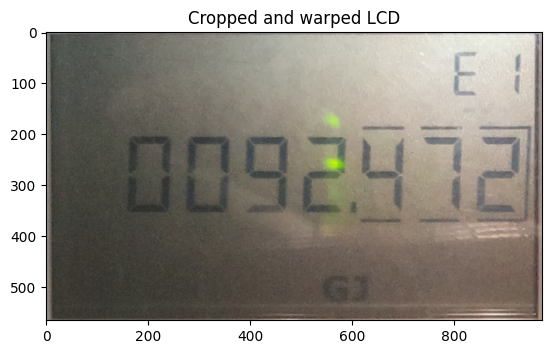

In [146]:
def get_euler_distance(pt1, pt2):
    return np.sqrt(np.square(pt1[0] - pt2[0]) + np.square(pt1[1] - pt2[1]))

display_roi = np.float32(display_roi)
display_width_1 = get_euler_distance(display_roi[0], display_roi[1])
display_width_2 = get_euler_distance(display_roi[3], display_roi[2])
display_height_1 = get_euler_distance(display_roi[0], display_roi[3])
display_height_2 = get_euler_distance(display_roi[1], display_roi[2])
display_width = int(max(display_width_1, display_width_2))
display_height = int(max(display_height_1, display_height_2))
display_dst_pts = np.float32([[0, 0], [display_width, 0], [display_width, display_height], [0, display_height]])

# Extract LCD image and perform perspective transformation
transform_matrix = cv2.getPerspectiveTransform(display_roi, display_dst_pts)
warp = cv2.warpPerspective(orig, transform_matrix, (display_width, display_height), flags=cv2.INTER_LINEAR)

print(f'W x H = {display_width} x {display_height}: {display_contour}')
plt.imshow(warp)
plt.title('Cropped and warped LCD')

Text(0.5, 1.0, 'Image prepared for OCR')

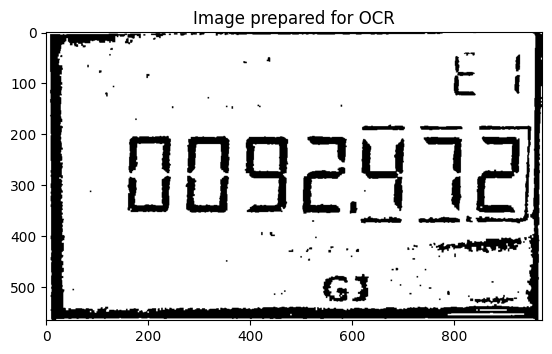

In [147]:
def smooth_image(img):
    _, th1 = cv2.threshold(img, 180, 255, cv2.THRESH_BINARY)
    _, th2 = cv2.threshold(th1, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    blur = cv2.GaussianBlur(th2, (3, 3), 0)
    _, th3 = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return th3

def remove_noise_and_smooth(img):
    # Apply dilation and erosion to remove some noise
    kernel = np.ones((3, 3), np.uint8)
    filtered = cv2.adaptiveThreshold(img.astype(np.uint8), 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 61, 8)
    opening = cv2.morphologyEx(filtered, cv2.MORPH_OPEN, kernel)
    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)
    img = smooth_image(img)
    or_image = cv2.bitwise_or(img, closing)
    return or_image

# Prepare image for OCR with tesseract
ocr_image = warp.copy()
ocr_image = cv2.cvtColor(ocr_image, cv2.COLOR_BGR2GRAY)
ocr_image = remove_noise_and_smooth(ocr_image)

plt.imshow(ocr_image, cmap='gray')
plt.title('Image prepared for OCR')

Text(0.5, 1.0, 'Meter readings: 0092472')

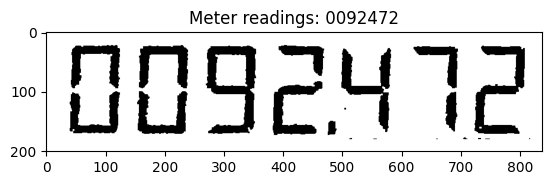

In [148]:
def recognize(roi):
    tesseract_config = '--psm 8 --oem 3 -c tessedit_char_whitelist=0123456789 --tessdata-dir ./app/ssd'
    text = pytesseract.image_to_string(roi, lang="ssd", config=tesseract_config)
    return text

# Knowing the location of the readings within the LCD ROI we can extract the readings ROI
readings_left_edge = int(display_width * 0.144)
readings_right_edge = int(display_width * 0.965)
readings_top_edge = int(display_height * 0.360)
readings_bottom_edge = int(display_height * 0.645)
readings_roi = ocr_image[readings_top_edge:readings_bottom_edge, readings_left_edge:readings_right_edge]

# Pad image with white border to improve OCR accuracy
readings_roi = cv2.copyMakeBorder(readings_roi, 20, 20, 20, 20, cv2.BORDER_CONSTANT, value=(255,255,255))

# Perform OCR
text = recognize(readings_roi).strip()

plt.imshow(readings_roi, cmap='gray')
plt.title(f'Meter readings: {text}')